In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '/mnt/c/Users/phoen/Documents/GitHub/spateo-release')

import matplotlib.pyplot as plt
import numpy as np
import skimage
import sklearn
import spateo as st

plt.style.use('default')
plt.rcParams['image.interpolation'] = 'none'
%config InlineBackend.figure_format='retina'

/home/lioscro/miniconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/lioscro/miniconda3/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper
/home/lioscro/miniconda3/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and opera

In [2]:
%%time
adata = st.io.read_bgi_agg('/mnt/e/scratch/stereo/SS200000135TL_D1_Intron_Bin1.txt.gz', '/mnt/e/scratch/stereo/SS200000135IL-D1_mrna.matched.ssDNA.tif', scale=0.5, scale_unit='um')[3000:14000,6000:20000].copy()
adata

CPU times: user 50.8 s, sys: 5.01 s, total: 55.8 s
Wall time: 1min 11s


AnnData object with n_obs × n_vars = 11000 × 14000
    uns: '__type', 'pp', 'spatial'
    layers: 'stain', 'spliced', 'unspliced'

CPU times: user 3min 9s, sys: 117 ms, total: 3min 9s
Wall time: 3min 9s


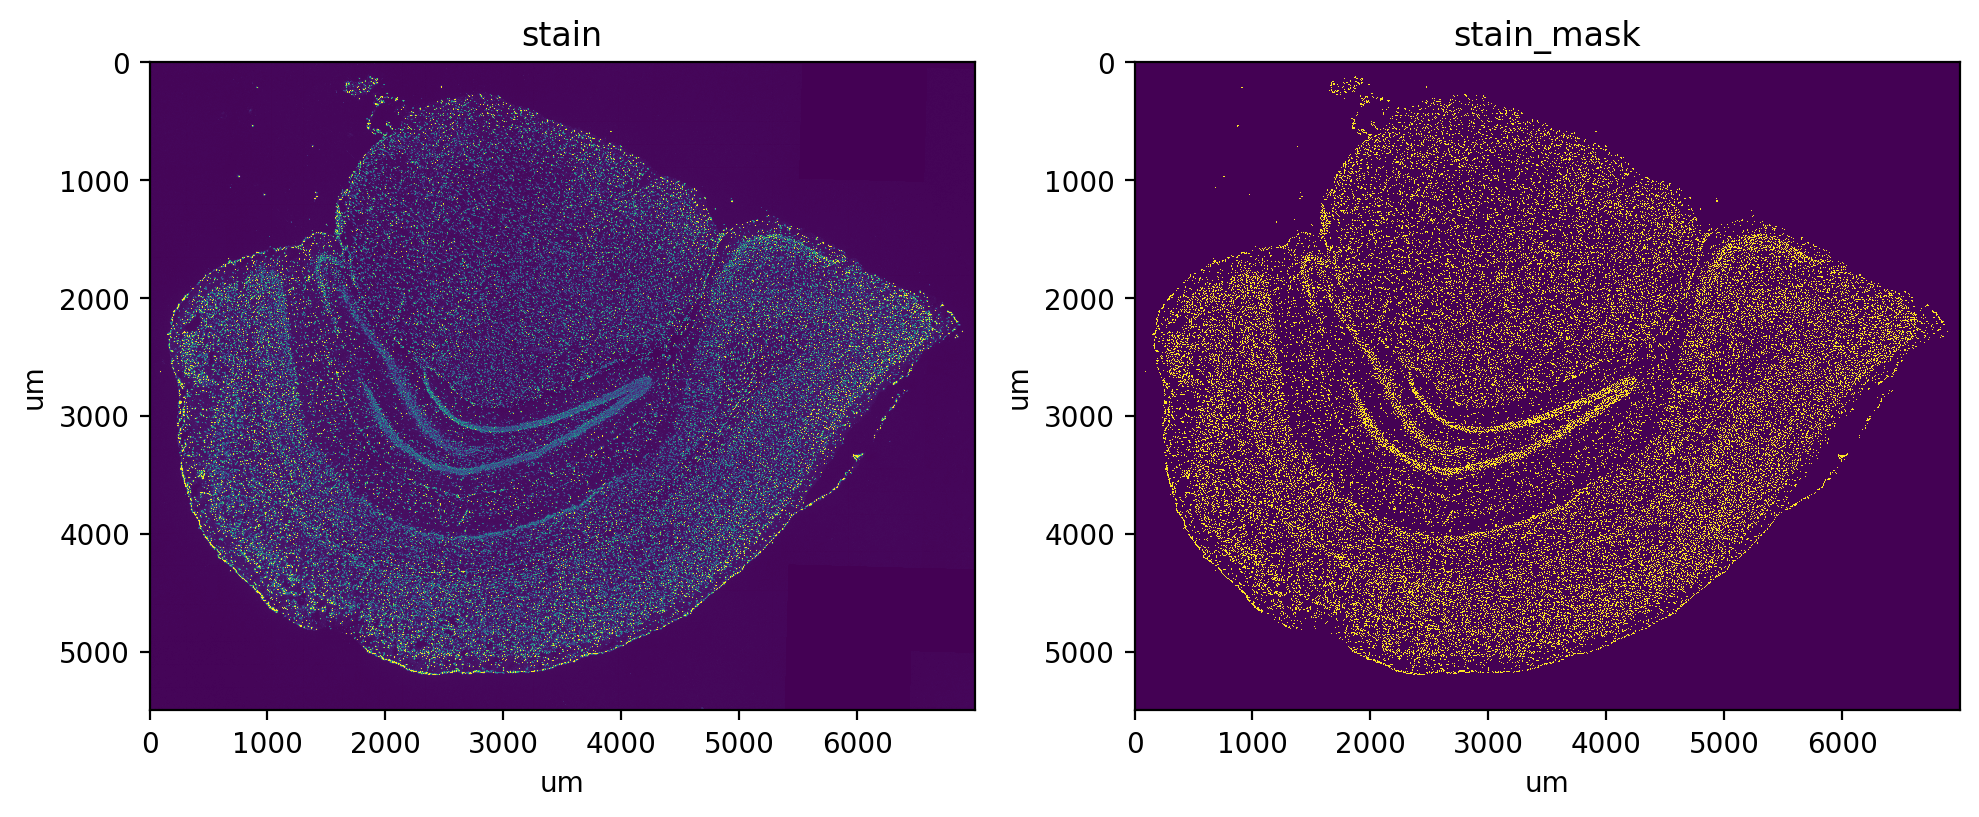

In [3]:
%%time
st.pp.segmentation.mask_nuclei_from_stain(adata)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata, 'stain', ax=axes[0])
st.pl.imshow(adata, 'stain_mask', ax=axes[1])

CPU times: user 3min 45s, sys: 4.4 s, total: 3min 50s
Wall time: 3min 49s


(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot:title={'center':'unspliced_bins'}, xlabel='um', ylabel='um'>)

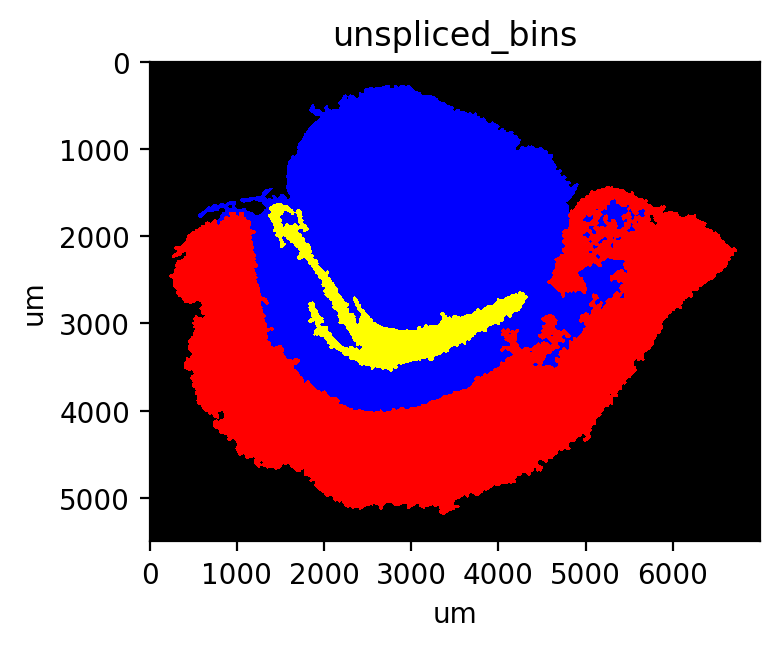

In [4]:
%%time
st.pp.segmentation.segment_densities(adata, 'unspliced', 10, k=7, distance_threshold=6)
st.pl.imshow(adata, 'unspliced_bins', labels=True)

CPU times: user 6min 13s, sys: 10.8 s, total: 6min 24s
Wall time: 3min 27s


(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot:title={'center':'unspliced_mask'}, xlabel='um', ylabel='um'>)

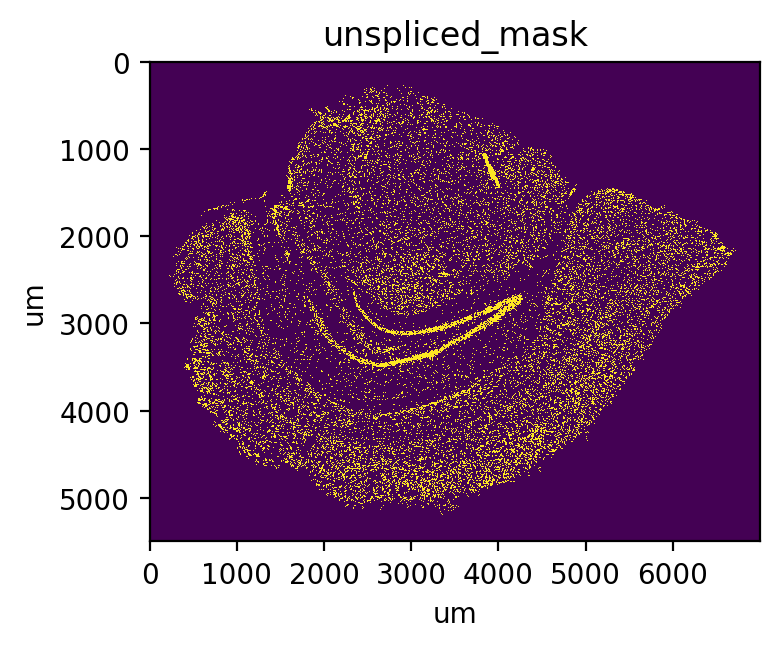

In [5]:
%%time
st.pp.segmentation.score_and_mask_pixels(
    adata, 'unspliced', k=13, method='EM+BP',
    em_kwargs=dict(downsample=0.001, seed=2022), bp_kwargs=dict(n_threads=16),
)
st.pl.imshow(adata, 'unspliced_mask')

In [6]:
%%time
# `transform_layers` specifies which layers should be transformed based on the final affine transformation.
# These layers will be overwridden.
st.pp.segmentation.refine_alignment(adata, transform_layers=['stain', 'stain_mask'])

Loss 0.3127: 100%|██████████| 100/100 [10:08<00:00,  6.08s/it]


CPU times: user 46min 20s, sys: 20min 58s, total: 1h 7min 19s
Wall time: 10min 13s


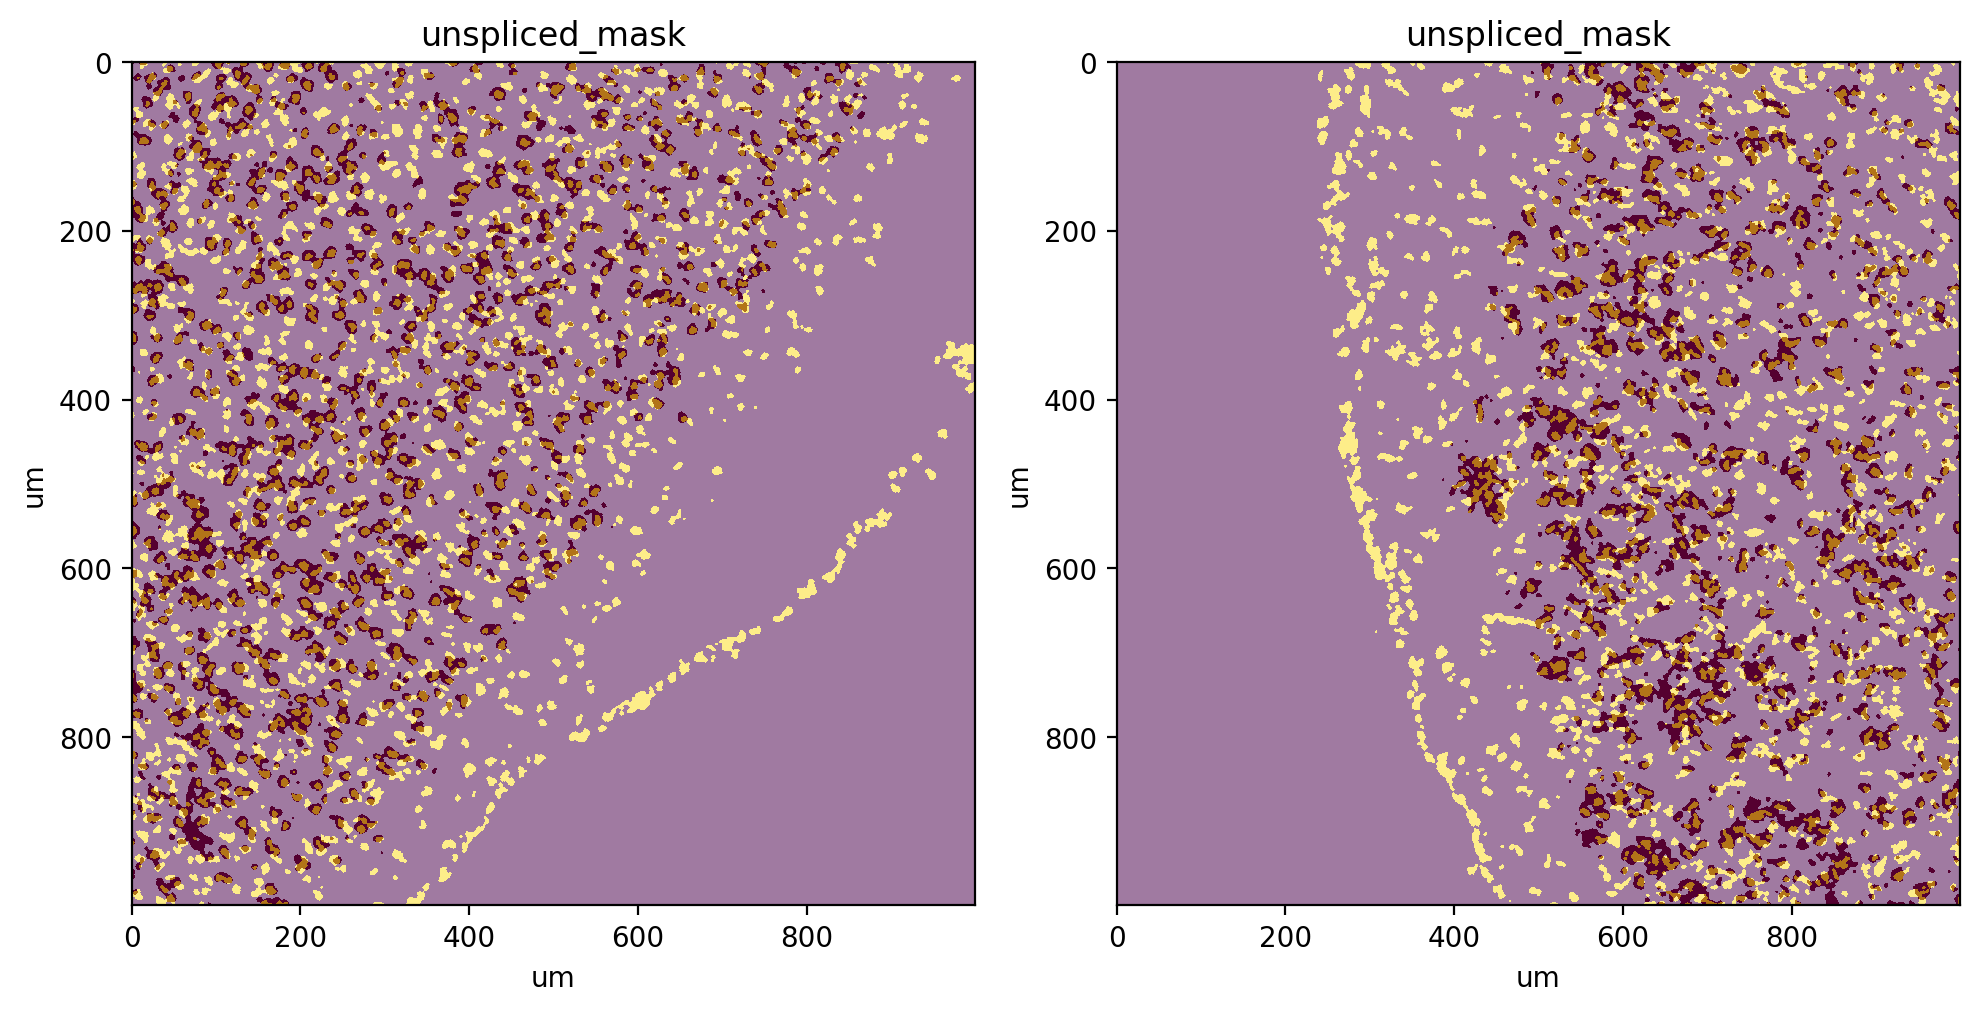

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), tight_layout=True)
st.pl.imshow(adata[6000:8000,10000:12000], 'stain_mask', ax=axes[0])
st.pl.imshow(adata[6000:8000,10000:12000], 'unspliced_mask', ax=axes[0], alpha=0.5, cmap='Reds')

st.pl.imshow(adata[6000:8000,0:2000], 'stain_mask', ax=axes[1])
st.pl.imshow(adata[6000:8000,0:2000], 'unspliced_mask', ax=axes[1], alpha=0.5, cmap='Reds')

In [8]:
%%time
st.pp.segmentation.watershed_markers(adata)

CPU times: user 25.3 s, sys: 0 ns, total: 25.3 s
Wall time: 3.46 s


CPU times: user 39.9 s, sys: 2.23 s, total: 42.1 s
Wall time: 41.7 s


(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot:title={'center':'stain_labels'}, xlabel='um', ylabel='um'>)

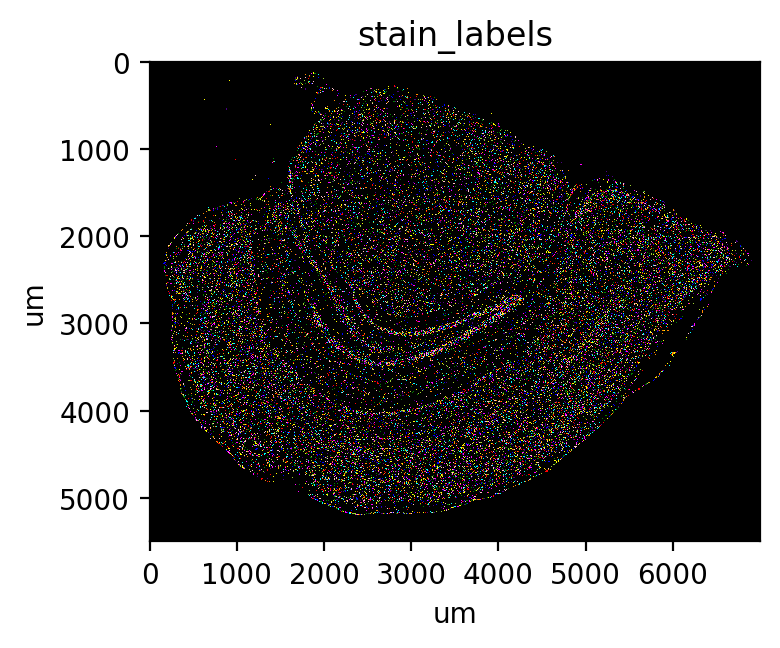

In [9]:
%%time
st.pp.segmentation.watershed(adata)

st.pl.imshow(adata, 'stain_labels', labels=True)

CPU times: user 1.11 s, sys: 0 ns, total: 1.11 s
Wall time: 1.11 s


(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot:title={'center':'stain_cell_mask'}, xlabel='um', ylabel='um'>)

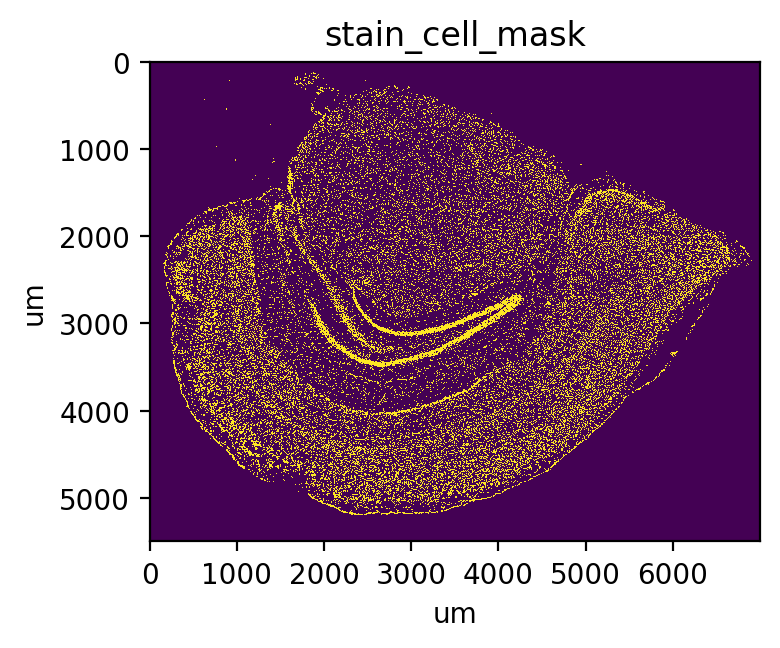

In [10]:
%%time
st.pp.segmentation.mask_cells_from_stain(adata, out_layer='stain_cell_mask')
st.pl.imshow(adata, 'stain_cell_mask')

CPU times: user 51.2 s, sys: 3.01 s, total: 54.2 s
Wall time: 54.7 s


(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot:title={'center':'cell_labels'}, xlabel='um', ylabel='um'>)

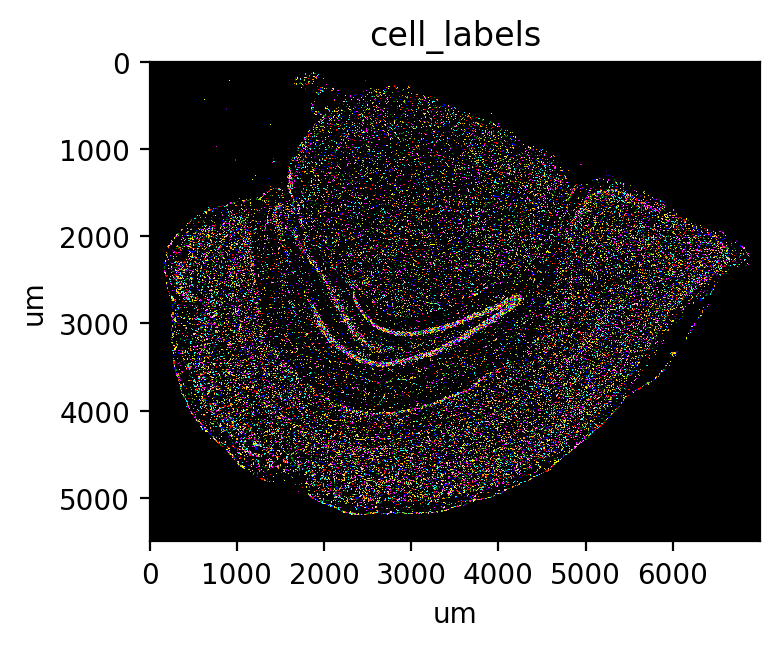

In [11]:
%%time
st.pp.segmentation.watershed(
    adata,
    mask_layer='stain_cell_mask',
    markers_layer='stain_labels',
    out_layer='cell_labels',
)
st.pl.imshow(adata, 'cell_labels', labels=True)

CPU times: user 2min 9s, sys: 1min 2s, total: 3min 11s
Wall time: 1min 22s


(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot:title={'center':'unspliced_labels'}, xlabel='um', ylabel='um'>)

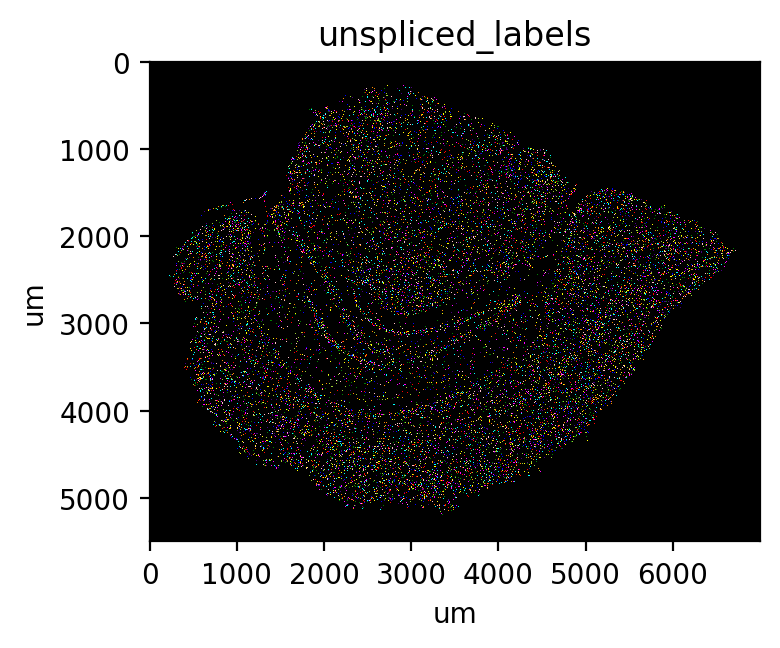

In [12]:
%%time
st.pp.segmentation.label_connected_components(adata, 'unspliced')
st.pl.imshow(adata, 'unspliced_labels', labels=True)

(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot:title={'center':'X'}, xlabel='um', ylabel='um'>)

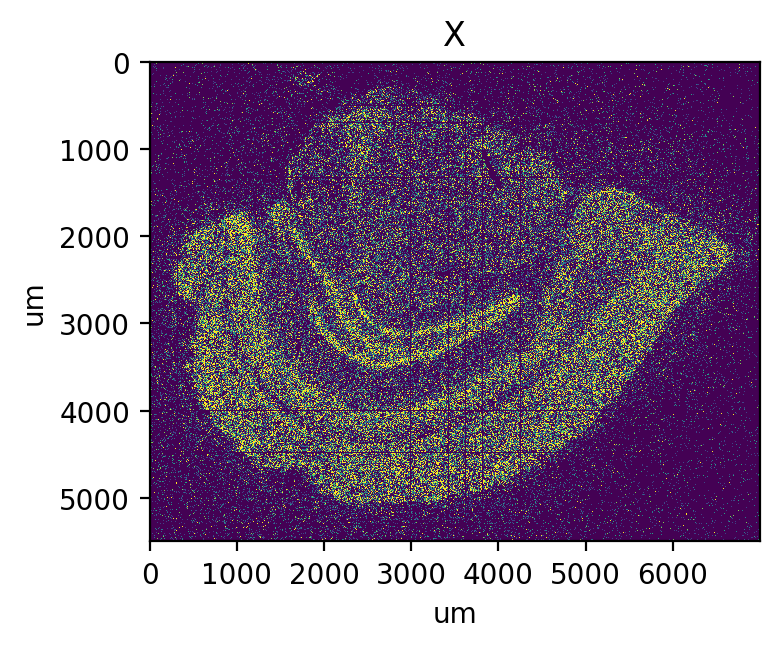

In [13]:
st.pl.imshow(adata, 'X', vmax=5)

CPU times: user 4min 34s, sys: 0 ns, total: 4min 34s
Wall time: 4min 34s


(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot:title={'center':'X_bins'}, xlabel='um', ylabel='um'>)

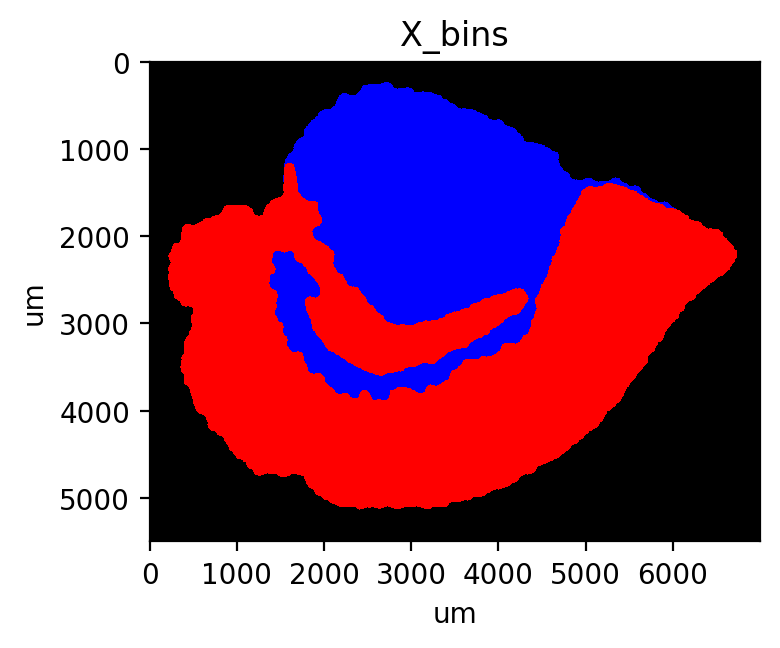

In [14]:
%%time
st.pp.segmentation.segment_densities(adata, 'X', 10, k=5, distance_threshold=20, dk=21)
st.pl.imshow(adata, 'X_bins', labels=True)

In [15]:
%%time
st.pp.segmentation.score_and_mask_pixels(
    adata, 'X', k=15, method='EM+BP',
    em_kwargs=dict(downsample=0.001, seed=2022), bp_kwargs=dict(n_threads=16),
    certain_layer='unspliced_labels'
)

CPU times: user 6min 10s, sys: 7.71 s, total: 6min 18s
Wall time: 3min 41s


CPU times: user 9min 18s, sys: 0 ns, total: 9min 18s
Wall time: 9min 16s


(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot:title={'center':'X_labels'}, xlabel='um', ylabel='um'>)

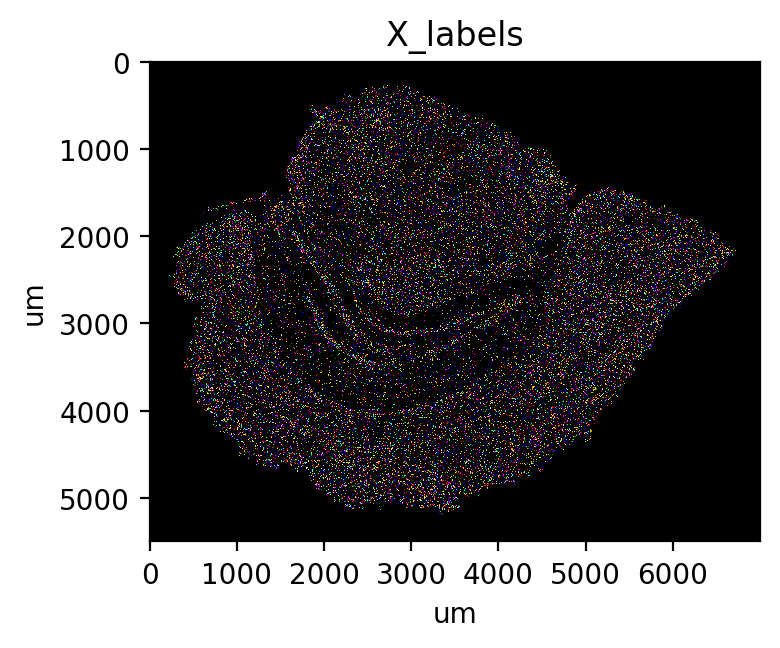

In [16]:
%%time
st.pp.segmentation.expand_labels(
    adata, 'unspliced', distance=5, max_area=400, mask_layer='X_mask', out_layer='X_labels'
)
st.pl.imshow(adata, 'X_labels', labels=True)

In [17]:
adata.write('data/full_segmentation.h5ad', compression='gzip')